## First Approach : CNN + MLP (Pre-trained with Supervised Contrastive Learning)

In [19]:
#Import All libraries 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import optuna
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning.losses import SupConLoss
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [11]:
#Perfom the transformations necessary 
transform = transforms.Compose([
    transforms.ToTensor(),                     #Transform the image into a tensor 
    transforms.Normalize((0.1307,), (0.3081,)) #Normalize the data
])

# Load the MNIST Dataset
full_train_data = datasets.MNIST(root="D:\MNIST\MNIST_Train", train=True, download=False, transform = transform)
test_data = datasets.MNIST(root="D:\MNIST\MNIST_Test", train=False, download=False, transform= transform)

# This seed is used to make sure the same split will happen for all approaches
torch.manual_seed(42)  

# Defining the sets that are going to be used for training and Gridsearch
train_data = int(0.7 * len(full_train_data))  # 70% for training
train_gridsearch = len(full_train_data) - train_data # 30% for gridsearch

# Get the training sets 
train_data, train_gridsearch = random_split(full_train_data, [train_data, train_gridsearch])

# Split the training datasets, one for the training of the CNN and one for the training of the MLP 
train_CNN = int(0.6 * len(train_data))
train_MLP = len(train_data) - train_CNN
train_CNN, train_MLP = random_split(train_data, [train_CNN, train_MLP])

# Make the Training and Validation split of the train_gridsearch set
train_gridsearch2 = int(0.8 * len(train_gridsearch))
validation_gridsearch = len(train_gridsearch) - train_gridsearch2
train_gridsearch2, validation_gridsearch = random_split(train_gridsearch, [train_gridsearch2, validation_gridsearch])

# Make the split of the train_gridsearch2 for the CNN and the MLP
train_gridsearch2_CNN = int(0.6 * len(train_gridsearch2))
train_gridsearch2_MLP = len(train_gridsearch2) - train_gridsearch2_CNN
train_gridsearch2_CNN, train_gridsearch2_MLP = random_split(train_gridsearch2, [train_gridsearch2_CNN, train_gridsearch2_MLP])

# the device specifies where the tensor or model should be stored and computations should be performed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class CNNEncoder(nn.Module): #Encoder as we're only interest in the final embedding provided by the CNN 
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.3) #Dropout
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * 7 * 7, 128)  # Output: 128-dimension embeddings

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14
        
        x = self.dropout1(F.relu(self.conv3(x))) #Adding Dropout
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 7x7
        
        x = x.view(-1, 256 * 7 * 7)  # Flatten
        x = self.fc(x)  # Output embeddings
        
         # Normalize embeddings to lie on unit hypersphere
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        
        return x

class MLPClassifier(nn.Module): # MLP projection Head 
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout2 = nn.Dropout(p=0.3) #Dropout
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.dropout2(F.relu(self.fc1(x))) #Adding Dropout
        x = self.fc2(x)
        return x

In [22]:
# Initialize accuracy calculator
#accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), knn_func=None)

class ContrastiveTrainer:
    def __init__(self, encoder, classifier, criterion, optimizer):
        self.encoder = encoder
        self.classifier = classifier
        self.criterion = criterion
        self.optimizer = optimizer

    def train_contrastive(self, train_loader, epochs):
        self.encoder.train()
        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Forward pass through the encoder
                features = self.encoder(images)

                # Compute supervised contrastive loss
                loss = self.criterion(features, labels)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            print(f'Epoch [{epoch + 1}/{epochs}], Contrastive Loss: {total_loss / len(train_loader):.4f}')
    
    def train_classifier(self, train_loader, epochs):
        self.encoder.eval()  # Freeze the encoder for classifier training
        self.classifier.train()
        
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Extract frozen features
                with torch.no_grad():
                    features = self.encoder(images)

                # Forward pass through the classifier
                outputs = self.classifier(features)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

            accuracy = correct / len(train_loader.dataset)
            print(f'Epoch [{epoch + 1}/{epochs}], Cross Entropy Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%')

   # def evaluate_embeddings(self, test_loader):
    #    self.encoder.eval()
   #     all_embeddings = []
  #      all_labels = []
#
       # with torch.no_grad():
       #       for images, labels in test_loader:
       #            images, labels = images.to(device), labels.to(device)
       #          features = self.encoder(images)
       #          
       #         all_embeddings.append(features.cpu())
       #         all_labels.append(labels.cpu())
       #
       #all_embeddings = torch.cat(all_embeddings)
       # all_labels = torch.cat(all_labels)

       # print(accuracy_calculator.get_accuracy(all_embeddings, all_labels, all_embeddings, all_labels))

    def test_classifier(self, test_loader, num_classes=10):
        self.encoder.eval()
        self.classifier.eval()
        
        # Variables to store predictions and true labels for AUC/ROC/Confusion Matrix
        all_probs = []
        all_labels = []
        all_preds = []
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Get features and outputs
                features = self.encoder(images)
                outputs = self.classifier(features)
                
                # Convert logits to probabilities using softmax
                probs = F.softmax(outputs, dim=1)
                
                # Record the true labels and predicted probabilities
                all_labels.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                
                # Get predicted class from the output (class with max probability)
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Flatten the collected lists
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        # Calculate test accuracy
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        # --- ROC and AUC computation ---
        # One-hot encode the labels
        labels_one_hot = np.eye(num_classes)[all_labels]

        # Compute ROC and AUC for each class
        roc_auc = {}
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_one_hot[:, i], all_probs[:, i])
            auc = roc_auc_score(labels_one_hot[:, i], all_probs[:, i])
            roc_auc[f'Class {i}'] = auc
            print(f'Class {i} AUC: {auc:.4f}')
            
        # Plot the ROC curve for each class
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # Overall macro AUC score
        overall_auc = roc_auc_score(labels_one_hot, all_probs, average='macro')
        print(f'Overall AUC (macro): {overall_auc:.4f}')
        
        # --- Confusion Matrix ---
        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()





In [14]:
# Hyperparameter tuning with Optuna
def objective(trial):

    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)
    
    # Create data loaders
    train_gridsearch2_CNN_loader = DataLoader(train_gridsearch2_CNN, batch_size=batch_size, shuffle=True)
    train_gridsearch2_MLP_loader = DataLoader(train_gridsearch2_MLP, batch_size=batch_size, shuffle=True)
    validation_gridsearch_loader = DataLoader(validation_gridsearch, batch_size=batch_size, shuffle=False)


    encoder = CNNEncoder().to(device)
    classifier = MLPClassifier().to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
    contrastive_loss = SupConLoss().to(device)
    
    trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)
    
    # Train the model
    trainer.train_contrastive(train_gridsearch2_CNN_loader, epochs=5)  # Train for fewer epochs for tuning speed
    trainer.train_classifier(train_gridsearch2_MLP_loader, epochs=3)
    
    # Evaluate on validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_gridsearch_loader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [16]:
# Run Optuna study
study = optuna.create_study(study_name ="Hyperparameter_Tunning",direction='maximize')
study.optimize(objective, n_trials=4)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-10-19 16:51:27,689] A new study created in memory with name: Hyperparameter_Tunning


Epoch [1/5], Contrastive Loss: 2.4139
Epoch [2/5], Contrastive Loss: 2.0206
Epoch [3/5], Contrastive Loss: 1.9348
Epoch [4/5], Contrastive Loss: 1.8816
Epoch [5/5], Contrastive Loss: 1.8568
Epoch [1/3], Cross Entropy Loss: 1.9847, Accuracy: 74.72%
Epoch [2/3], Cross Entropy Loss: 0.9257, Accuracy: 96.94%
Epoch [3/3], Cross Entropy Loss: 0.3157, Accuracy: 98.30%


[I 2024-10-19 17:02:08,205] Trial 0 finished with value: 0.9755555555555555 and parameters: {'lr': 0.00073634309322577, 'batch_size': 64}. Best is trial 0 with value: 0.9755555555555555.


Epoch [1/5], Contrastive Loss: 1.6913
Epoch [2/5], Contrastive Loss: 1.3219
Epoch [3/5], Contrastive Loss: 1.2361
Epoch [4/5], Contrastive Loss: 1.1856
Epoch [5/5], Contrastive Loss: 1.1482
Epoch [1/3], Cross Entropy Loss: 1.8266, Accuracy: 74.83%
Epoch [2/3], Cross Entropy Loss: 0.6415, Accuracy: 97.85%
Epoch [3/3], Cross Entropy Loss: 0.2212, Accuracy: 98.33%


[I 2024-10-19 17:13:53,047] Trial 1 finished with value: 0.9816666666666667 and parameters: {'lr': 0.0004634127289000916, 'batch_size': 32}. Best is trial 1 with value: 0.9816666666666667.


Epoch [1/5], Contrastive Loss: 2.4020
Epoch [2/5], Contrastive Loss: 2.0454
Epoch [3/5], Contrastive Loss: 1.9528
Epoch [4/5], Contrastive Loss: 1.9093
Epoch [5/5], Contrastive Loss: 1.8731
Epoch [1/3], Cross Entropy Loss: 2.2220, Accuracy: 51.56%
Epoch [2/3], Cross Entropy Loss: 2.0026, Accuracy: 93.56%
Epoch [3/3], Cross Entropy Loss: 1.6749, Accuracy: 96.61%


[I 2024-10-19 17:24:27,036] Trial 2 finished with value: 0.9633333333333334 and parameters: {'lr': 0.00022159875704446812, 'batch_size': 64}. Best is trial 1 with value: 0.9816666666666667.


Epoch [1/5], Contrastive Loss: 1.7775
Epoch [2/5], Contrastive Loss: 1.4112
Epoch [3/5], Contrastive Loss: 1.3035
Epoch [4/5], Contrastive Loss: 1.2391
Epoch [5/5], Contrastive Loss: 1.2045
Epoch [1/3], Cross Entropy Loss: 2.2564, Accuracy: 20.80%
Epoch [2/3], Cross Entropy Loss: 2.1288, Accuracy: 43.77%
Epoch [3/3], Cross Entropy Loss: 1.9374, Accuracy: 74.88%


[I 2024-10-19 17:35:43,164] Trial 3 finished with value: 0.8427777777777777 and parameters: {'lr': 8.379672000559088e-05, 'batch_size': 32}. Best is trial 1 with value: 0.9816666666666667.


Best hyperparameters:  {'lr': 0.0004634127289000916, 'batch_size': 32}


In [24]:
# Use best hyperparameters to train the final model
best_params = study.best_params
train_CNN_loader = DataLoader(train_CNN, batch_size=best_params['batch_size'], shuffle=True)
train_MLP_loader = DataLoader(train_MLP, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

# 
encoder = CNNEncoder().to(device)
classifier = MLPClassifier().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=best_params['lr'])
contrastive_loss = SupConLoss().to(device)


trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)

# Final training and testing
trainer.train_contrastive(train_CNN_loader, epochs=15)
trainer.train_classifier(train_MLP_loader, epochs=10)

Test Accuracy: 99.42%
Class 0 AUC: 1.0000
Class 1 AUC: 1.0000
Class 2 AUC: 1.0000
Class 3 AUC: 1.0000
Class 4 AUC: 0.9998
Class 5 AUC: 1.0000
Class 6 AUC: 1.0000
Class 7 AUC: 1.0000
Class 8 AUC: 0.9999
Class 9 AUC: 0.9997


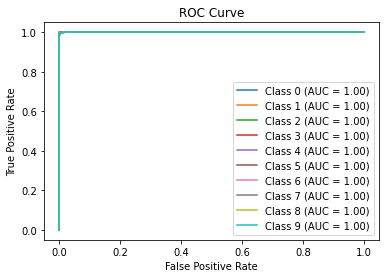

Overall AUC (macro): 0.9999


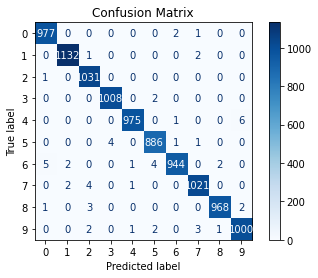

In [20]:
#Test the classifier
trainer.test_classifier(test_loader)